In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from lightfm import LightFM, cross_validation
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
from lightfm.data import Dataset

from matplotlib import pyplot as plt
from scipy.stats import mode

import nltk
from nltk.corpus import stopwords

from enum import Enum, auto
from ipywidgets import Dropdown
import pickle

/Users/janpetr/anaconda3/lib/python3.11/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


## 🔥 Models used:
- <b>LightFM</b> due to its ability to combine collaborative filtering with user and item features. Perfect for tackling the cold-start problem.
- <b>Cosine Similarity</b> for its ability to effectivelly recommend products based on item metadata.

<h1>🔥 Table of contents:</h1>

<ul>
    
- Data exploration, data preprocessing, input preparation for LightFM
- LightFM
    - Model training
    - Performance evaluation
    - Predictions for random user within the dataset
    - Predictions for new user based on ratings
    - Predictions for new user without ratings, based on user features (Cold start problem)
    - Model saving and description of productionalization
    
- Cosine Similarity
    - Recommendation based on metadata similarity
    - Extending metadata by OpenAI API data (genre, pages no., keywords)
- Productionalisation description
</ul>

# Methods

In [2]:
class PredictionType(Enum):
    WORST = auto()
    BEST = auto()

In [3]:
def interactions_filtering(dataset):
    """
    Apply only on the training and validation dataset. We do not apply on test dataset - new interactions.
    
    Steps:
    - Removing interactions between Books and Users which are not in their respective datasets
    - Keeping only explicit feedback, removing implicit -> increase in effectiveness metrics
    - Keeping only Books that were rated 10 times or more -> increase in effectiveness metrics
    - Keeping only Users that rated 10 items or more -> increase in effectiveness metrics
    - Reducing the size of the dataset for memory reasons    
    """
    
    # Define common ISBNs and User-IDs
    common_ids_isbn = pd.merge(ratings, books, on="ISBN", how="inner")["ISBN"].unique()
    common_ids_userid = pd.merge(ratings, users, on="User-ID", how="inner")["User-ID"].unique()

    # Remove interactions
    dataset = dataset[dataset["ISBN"].isin(common_ids_isbn) & dataset["User-ID"].isin(common_ids_userid)]
    
    # Only explicit feedback
    dataset = dataset[dataset["Book-Rating"] > 0]
    
    # Books rated 10 times and more
    dataset = dataset.groupby("ISBN").filter(lambda x: len(x)>=10)
    
    # Users who rated 10 items and more
    dataset = dataset[dataset.groupby("User-ID").ISBN.transform('nunique')>=10]
    
    # Size of the dataset
    #if len(dataset) > 100000:
    #    dataset = dataset.sample(100000)
    
    return dataset

def interactions_preprocessing(dataset):
    """
    Apply on training, validation and test dataset.
    
    Preprocessing steps:
    - Keep only ratings that lead to potential recommendations (7+).
    - Square the ratings to increase the importance of positive ratings and decrease the importance of negative ratings.
    - Each user has a different baseline rating. Cleanse based on baseline ratings.

    Disclaimer: None of the steps had a positive impact on the metrics. Eventually none were implemented.
    """
    
    # Keeping original state of the rating (for printing)
    dataset["OriginalRating"] = dataset["Book-Rating"]
    
    # Keep only ratings 7+
    #dataset = dataset[dataset["Book-Rating"]>7]
    
    # Square  
    #dataset["Book-Rating"] = dataset["Book-Rating"].transform(lambda x: x*x)
    
    # Cleanse based on baseline ratings
    #dataset["Book-Rating"] = dataset.groupby("User-ID")["Book-Rating"].transform(lambda x: (x - x.mean()) / x.std()) #" "
    #dataset["Book-Rating"] = dataset["Book-Rating"].fillna(0)
    
    return dataset

def split_location(location):
    """
    Splitting location tag based on divider. Keeping only the last three.
    """
    parts = location.split(",")

    while len(parts) < 3:
        parts.insert(0, "")  
    city = parts[-3].strip() if parts[-1] else "" 
    region = parts[-2].strip() if len(parts) > 1 and parts[-2] else ""
    country = parts[-1].strip() if len(parts) > 2 and parts[-3] else ""
    
    return pd.Series([city, region, country], index=['city', 'region', 'country'])

def age_bucket(age):
    """
    Rounding to the nearest 10.
    """
    age = round(age/10)*10
    return age

def build_interactions(dataframe, dataset):
    """
    Preparing interactions for LightFM's desired input.
    """
    dataset_tuple = list(zip(dataframe["User-ID"], dataframe["ISBN"], dataframe["Book-Rating"]))
    interactions, weights = dataset.build_interactions(i for i in dataset_tuple)
    return interactions, weights

def check_isbns(isbn_list):
    """
    Check if an ISBN from new interactions is part of the books dataset.
    """
    isbn_set = set(isbn_list)
    books_isbn_set = set(books["ISBN"])
    
    common_isbns = isbn_set.intersection(books_isbn_set)
    
    invalid_isbns = [x for x in isbn_set if x not in books_isbn_set]
    
    print(f"{len(common_isbns)}/{len(isbn_set)} valid ISBNs.")
    
    if len(common_isbns) != len(isbn_set):
        print("")
        print ("Invalid ISBNs:")
        for isbn in invalid_isbns:
            print(isbn)

def previous_ratings(userid, noitems=None):
    """
    Prints user's previous ratings.
    """
    user_ratings = ratings[ratings["User-ID"]==userid]
    user_books = pd.merge(user_ratings, books, on="ISBN")
    user_books = user_books.sort_values(by="Book-Rating", ascending=False)
    
    if noitems is not None:
        user_books = user_books[:noitems]

    print(f"User ID: {userid}. Previous ratings (highest to lowest):")

    for _, row in user_books.iterrows():
        print(f"- {int((row['OriginalRating']))}*, {row['Book-Title']}, {row['Book-Author']}, {row['Year-Of-Publication']} (ISBN: {row['ISBN']})")
        
def prediction(userid, where, noitems, remove_rated):
    """
    Prints user's predictions.
    
    Inputs
    - User ID (int)
    - Where - BEST or WORST performing (enum PredictionType.BEST / WORST)
    - Number of printed items (int)
    - Remove already rated items (True/False)
    """
    
    # Transforming User ID from original datasets to LightFM's internal IDs
    usercode = user_id_map.get(userid)
    
    # Predict values for all items in dataset
    _, n_items = train_interactions.shape
    scores = pd.Series(model.predict(usercode,np.arange(n_items)))

    items = pd.DataFrame(scores)

    items.index = items.index.map(item_id_inverse_map)
    items = items.reset_index(names="ISBN").rename(columns={0: "prob"})

    # Remove rated
    if remove_rated == True:
        ratedisbn = ratings[ratings["User-ID"]==userid]["ISBN"]
    elif remove_rated == False:
        ratedisbn = []

    booksfinal = pd.merge(books,items,on="ISBN",how="inner")

    # Which tail to print (Highest or Lowest predictions)
    if where == PredictionType.BEST:
        booksfinal = booksfinal.sort_values(by="prob", ascending=False)
        print(f"Predicted: best {noitems}:")
    elif where == PredictionType.WORST:
        booksfinal = booksfinal.sort_values(by="prob", ascending=True)
        print(f"Predictd: worst {noitems}:")

    for _, row in booksfinal[~booksfinal["ISBN"].isin(ratedisbn)][:noitems].iterrows():
        print(f"- {row['Book-Title']}, {row['Book-Author']}, {row['Year-Of-Publication']} (ISBN: {row['ISBN']}) {row['prob']}")
        
def get_mode(series):
    return mode(series)[0]

# Cosine Similarity 
vectorizer = CountVectorizer(analyzer='char', ngram_range=(1, 2))
def find_similarity(book1, book2):
    """
    Find similar items based on content string.
    """
    vectorized_data = vectorizer.fit_transform([book1, book2])
    cosine_sim = cosine_similarity(vectorized_data[0], vectorized_data[1])
    return cosine_sim[0][0]

<h1>Data Reading and Exploration</h1>

In [4]:
ratings = pd.read_csv("data/Ratings.csv")
books = pd.read_csv('data/Books.csv')
users = pd.read_csv("data/Users.csv")

/var/folders/g4/1x4xl1_92cj02tdf3gqfw5qm0000gn/T/ipykernel_64749/4156181754.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('data/Books.csv')


## Ratings

In [5]:
ratings.head(5)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [6]:
print(ratings["User-ID"].isna().sum())
print(ratings["ISBN"].isna().sum())
print(ratings["Book-Rating"].isna().sum())

0
0
0


In [7]:
print("Number of Explicit ratings (rating): ",len(ratings[ratings["Book-Rating"]>0]))
print("Number of Implicit ratings (product page view,...):  ",len(ratings[ratings["Book-Rating"]==0]))

Number of Explicit ratings (rating):  433671
Number of Implicit ratings (product page view,...):   716109


In [8]:
ratings_frequency = ratings[ratings["Book-Rating"]>0].groupby("User-ID")["ISBN"].nunique()

bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 25, 50, 100, 500, 1000, 10000]

labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11-15', '16-25', '26-50', '51-100', '101-500', '501-1000', '1001-10000']

categorized = pd.cut(ratings_frequency, bins=bins, labels=labels, right=True)

category_counts = categorized.value_counts().sort_index()

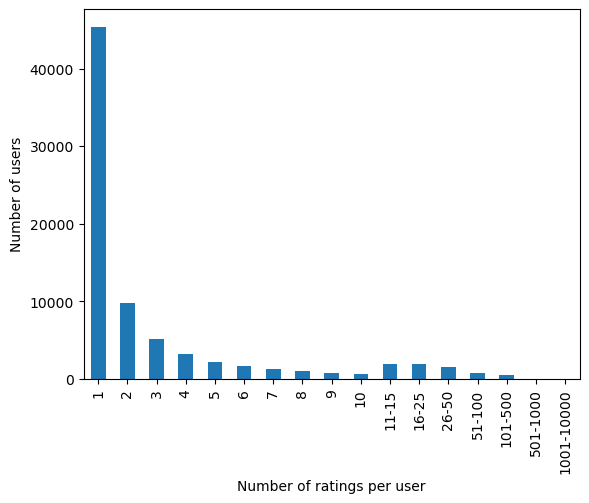

In [9]:
category_counts.plot(kind="bar")
plt.ylabel("Number of users")
plt.xlabel("Number of ratings per user")
plt.show()

# 🔥
- Huge portion of the dataset consists of users who rated only 1 item.
- This would lead to the user-item interaction matrix being to sparse, meaning too many blank spaces.
- The more dense (the opposite of sparse) the dataset is, the better for training collaborative-filtering models.

In [10]:
missing_from_users = ratings[~ratings['User-ID'].isin(users['User-ID'])]['User-ID'].unique()
missing_from_ratings_users = users[~users['User-ID'].isin(ratings['User-ID'])]['User-ID'].unique()

print("Missing",len(missing_from_users),"users from Users dataset.")
print("Missing",len(missing_from_ratings_users),"users from Ratings dataset.")

Missing 0 users from Users dataset.
Missing 173575 users from Ratings dataset.


In [11]:
missing_from_books = ratings[~ratings['ISBN'].isin(books['ISBN'])]['ISBN'].unique()
missing_from_ratings_books = books[~books['ISBN'].isin(ratings['ISBN'])]['ISBN'].unique()

print("Missing",len(missing_from_books),"books from Books dataset.")
print("Missing",len(missing_from_ratings_books),"books from Ratings dataset.")

Missing 70405 books from Books dataset.
Missing 1209 books from Ratings dataset.


## Users

In [12]:
users.head(5)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [13]:
users.isna().sum()

User-ID          0
Location         0
Age         110762
dtype: int64

In [14]:
print((users["Age"].isna().sum()/len(users))*100,"% of the Age feature is empty.")

39.71985741847105 % of the Age feature is empty.


In [15]:
users["Age"].value_counts()

Age
24.0     5687
25.0     5618
26.0     5547
23.0     5456
27.0     5383
         ... 
168.0       1
132.0       1
159.0       1
186.0       1
127.0       1
Name: count, Length: 165, dtype: int64

In [16]:
print("Minimum age:", min(users["Age"].dropna().values))
print("Maximum age:", max(users["Age"].dropna().values))

Minimum age: 0.0
Maximum age: 244.0


In [17]:
print(users["Age"].mean())
print(users["Age"].median())
print(users["Age"].mode()[0])

34.75143370454978
32.0
24.0


In [18]:
counts = users["Location"].apply(lambda item: item.count(','))
counts.value_counts()

Location
2    277348
3      1417
4        72
5        11
6         4
7         2
8         2
1         1
0         1
Name: count, dtype: int64

# 🔥
- Given the proportion of missing values, it's better to impute values than drop users.
- No other relevant info within this dataset to impute missing values based on.
- Idea: impute by ratings similarity.
- We need to take care of Age outliers.
- Location is mostly split between three values but can be split up to nine values. Need to take that into consideration when deriving City, Region and Country out of it.

## Books

In [19]:
books.head(5)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [20]:
books.isna().sum()

ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

In [21]:
# Checking unwanted words in the Book-Title that could potentially harm content based filtering

books[books["Book-Title"].str.contains("(Paperback)")]["Book-Title"].sample(5)

/var/folders/g4/1x4xl1_92cj02tdf3gqfw5qm0000gn/T/ipykernel_64749/3783307237.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  books[books["Book-Title"].str.contains("(Paperback)")]["Book-Title"].sample(5)


66762     Kristy's Big Day (Baby-Sitters Club (Paperback))
29933    The Recycled Citizen : A Sarah Kelling &amp; M...
78879    The Signet Book of American Humor (Signet Clas...
44477        Maisy Goes Shopping (Maisy Books (Paperback))
9411     Frequent Flyer (Kinky Friedman Novels (Paperba...
Name: Book-Title, dtype: object

# 🔥
- Number of missing values is okay to drop.
- Book-Title will need preprocessing to be adjusted so that the recommendations are not influenced by containing "Book 1" etc.

<h1>🔥 Data Preprocessing</h1>

<h2>Ratings</h2>

In [22]:
ratings_sum = len(ratings["Book-Rating"])
unique_users = len(ratings["User-ID"].unique())
unique_items = len(ratings["ISBN"].unique())

data_density = ratings_sum/(unique_users*unique_items)
print("Data density (before pre-processing)",data_density)

Data density (before pre-processing) 3.206771109452608e-05


In [23]:
"""
Filtering steps:
- Removing interactions between Books and Users which are not in their respective datasets
- Keeping only explicit feedback, removing implicit -> increase in effectiveness metrics
- Keeping only Books that were rated 10 times or more -> increase in effectiveness metrics
- Keeping only Users that rated 10 items or more -> increase in effectiveness metrics
- Reducing the size of the dataset for memory reasons 

"""
ratings = interactions_filtering(ratings)

In [24]:
"""
Preprocessing steps:
- Keep only ratings that lead to potential recommendations (7+).
- Square the ratings to increase the importance of positive ratings and decrease the importance of negative ratings.
- Each user has a different baseline rating. Cleanse based on baseline ratings.

Disclaimer: None of the steps had a positive impact on the metrics. Eventually none were implemented.
"""

ratings = interactions_preprocessing(ratings)

In [25]:
interactions_unique_users = ratings["User-ID"].unique()
interactions_unique_isbns = ratings["ISBN"].unique()

print("Unique users: ", len(interactions_unique_users))
print("Unique books: ", len(interactions_unique_isbns))

Unique users:  2653
Unique books:  5412


In [26]:
ratings_sum = len(ratings["Book-Rating"])
unique_users = len(ratings["User-ID"].unique())
unique_items = len(ratings["ISBN"].unique())

data_density = ratings_sum/(unique_users*unique_items)
print("Data density (after pre-processing)",data_density)

Data density (after pre-processing) 0.00482733153754455


<h2>Users (features)</h2>

### Preprocessing

In [27]:
# Splitting Location to City, Region and Country
users[["City", "Region", "Country"]] = users["Location"].apply(lambda x: split_location(x))

This step would be redundant for Content-based filtering but I think it's still relevant for LightFM model as it treats each feature as a stand-alone feature, not all of them together.

Content-based filtering works different than User and Item features in LightFM.

In [28]:
# Outliers reduction - replacement with NaN for future processing
users["Age"] = np.where(users["Age"].between(0, 13), np.nan, users["Age"])
users["Age"] = np.where(users["Age"] > 75, np.nan, users["Age"])

# Replacing NaN values with median value
users["Age"] = users["Age"].fillna(users["Age"].median())

# Age bucketing
users["Age"] = users["Age"].transform(lambda x: age_bucket(x))

# Removing users which are not present in the Ratings dataset
users = users[users["User-ID"].isin(set(interactions_unique_users))]

I wanted to try picking out users' favorite time periods (based on Year of Publication) and use it as a user feature:

In [29]:
ratings_books = pd.merge(ratings, books, on="ISBN", how="inner")
ratings_books = ratings_books[["User-ID", "Book-Rating", "Year-Of-Publication"]]

# Bucketing to periods (1990s, 2000s, 2010s,...)
ratings_books["Year-Of-Publication"] = ratings_books["Year-Of-Publication"].transform(lambda x: age_bucket(x))

# Only the most favorites with the rating 7+
ratings_books = ratings_books[ratings_books["Book-Rating"] > 6]

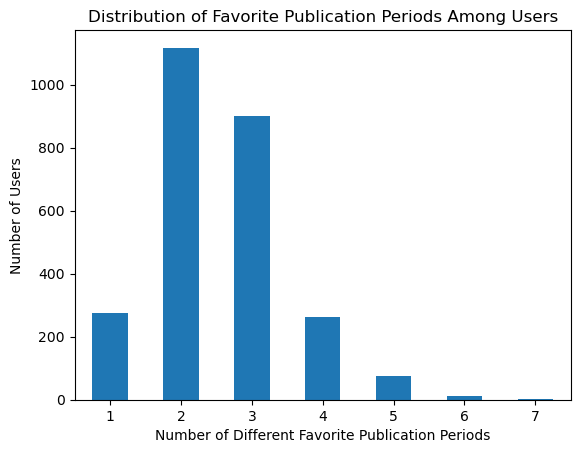

In [30]:
# How many favorite periods do users have

fav_periods_counts = ratings_books.groupby("User-ID")["Year-Of-Publication"].nunique()
periods_count_distribution = fav_periods_counts.value_counts().sort_index()

periods_count_distribution.plot(kind="bar")
plt.xlabel('Number of Different Favorite Publication Periods')
plt.ylabel('Number of Users')
plt.title('Distribution of Favorite Publication Periods Among Users')
plt.xticks(rotation=0)
plt.show()

In [31]:
# Preparation for the following step -> for computational reasons replacing rating with ranking
ratings_books["Book-Rating"] = ratings_books["Book-Rating"].rank(method='dense').astype(int)

# Giving more weight to bigger rating
ratings_books = ratings_books.loc[ratings_books.index.repeat(ratings_books['Book-Rating'])].reset_index(drop=True)

ratings_books = ratings_books[["User-ID", "Year-Of-Publication"]]

# Grouping with mode
ratings_books = ratings_books.groupby("User-ID")["Year-Of-Publication"].apply(get_mode)

In [32]:
ratings_books.value_counts()

Year-Of-Publication
2000    2330
1990     289
1980      16
0          3
1950       2
1960       2
1970       1
Name: count, dtype: int64

Given the small number of buckets and the skeweness towards a single bucket, I deemed this step as a dead-end. It will not provide much additional value in terms of variety and grouping users 

<h2>Books (features)</h2>

In [33]:
# Removing books which are not in the Ratings dataset
books = books[books["ISBN"].isin(set(interactions_unique_isbns))]

In [34]:
# Removing stopwords
def remove_stop_words(title):
    words = nltk.word_tokenize(title)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

stop_words = set(stopwords.words('english'))

books["Book-Title-Processed"] = books["Book-Title"].apply(remove_stop_words)

In [35]:
# Removing further unwanted words from the Book title

words_to_remove = ["(Paperback)",
                   "(Hardcover)",
                   ": A Novel",
                   "Book 1",
                   "Book 2",
                   "Book 3",
                   "Book 4",
                   "Book 5",
                   "Book 6",
                   "Book 7",
                   "Book 8",
                   "Book 9",
                   "Book 10",
                  ]

regex_pattern = r'\b(?:' + '|'.join(words_to_remove) + r')\b'

books["Book-Title-Processed"] = books["Book-Title-Processed"].str.replace(regex_pattern,"",regex=True)

In [36]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Book-Title-Processed
5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,Kitchen God 's Wife
18,0440234743,The Testament,John Grisham,1999,Dell,http://images.amazon.com/images/P/0440234743.0...,http://images.amazon.com/images/P/0440234743.0...,http://images.amazon.com/images/P/0440234743.0...,Testament
19,0452264464,Beloved (Plume Contemporary Fiction),Toni Morrison,1994,Plume,http://images.amazon.com/images/P/0452264464.0...,http://images.amazon.com/images/P/0452264464.0...,http://images.amazon.com/images/P/0452264464.0...,Beloved ( Plume Contemporary Fiction )
20,0609804618,Our Dumb Century: The Onion Presents 100 Years...,The Onion,1999,Three Rivers Press,http://images.amazon.com/images/P/0609804618.0...,http://images.amazon.com/images/P/0609804618.0...,http://images.amazon.com/images/P/0609804618.0...,Dumb Century : Onion Presents 100 Years Headli...
26,0971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,Wild Animus


<h1>Train/Valid split (Interactions)</h1>

In [37]:
train, valid = train_test_split(ratings, test_size=0.2, random_state=42)

In [38]:
print("Train", len(train), "hodnocení")
print("Unikátní uživatelé: ", len(train["User-ID"].unique()))
print("Unikátní knihy: ", len(train["ISBN"].unique()))
print("AVG počet hodnocení na uživatele: ", len(train) / len(train["User-ID"].unique()))
print("AVG počet hodnocení na knihu: ", len(train) / len(train["ISBN"].unique()))

Train 55448 hodnocení
Unikátní uživatelé:  2653
Unikátní knihy:  5390
AVG počet hodnocení na uživatele:  20.900113079532606
AVG počet hodnocení na knihu:  10.287198515769944


In [39]:
print("Valid", len(valid), "hodnocení")
print("Unikátní uživatelé: ", len(valid["User-ID"].unique()))
print("Unikátní knihy: ", len(valid["ISBN"].unique()))
print("AVG počet hodnocení na uživatele: ", len(valid) / len(valid["User-ID"].unique()))
print("AVG počet hodnocení na knihu: ", len(valid) / len(valid["ISBN"].unique()))

Valid 13863 hodnocení
Unikátní uživatelé:  2561
Unikátní knihy:  4463
AVG počet hodnocení na uživatele:  5.413119875048809
AVG počet hodnocení na knihu:  3.106206587497199


<h1>Input preparation</h1>

<h2>Features</h2>

In [40]:
# All unique features listed -> input for the model
unique_user_features = users[["Age", "City", "Region", "Country"]].values.flatten().tolist()

# All unique features with User ID -> input for the model
user_features_tpl = [(user_id, [age, city, region, country]) 
             for user_id, age, city, region, country 
             in zip(users["User-ID"], users["Age"], users["City"], users["Region"], users["Country"])]

In [41]:
# All unique features listed -> input for the model
unique_book_features = books[["Book-Title-Processed","Book-Author", "Year-Of-Publication", "Publisher"]].values.flatten().tolist()

# Veškeré features spojené s ISBN
book_features_tpl = [(isbn, [title, author, year, publisher]) 
             for isbn, title, author, year, publisher 
             in zip(books["ISBN"], books["Book-Title-Processed"], books["Book-Author"], books["Year-Of-Publication"], books["Publisher"])]

<h2>Building dataset</h2>

In [42]:
# Defining dataset

full_dataset = Dataset()
full_dataset.fit(users=interactions_unique_users, 
                 items=interactions_unique_isbns, 
                 user_features=unique_user_features,
                 item_features=unique_book_features
                )

# Mapping original User IDs and ISBNs to LightFM's internal IDs
user_id_map, user_features_map, item_id_map, item_features_map = full_dataset.mapping()

user_id_inverse_map = {v: k for k, v in user_id_map.items()}
item_id_inverse_map = {v: k for k, v in item_id_map.items()}

In [43]:
# Building features

user_features_matrix = full_dataset.build_user_features(user_features_tpl, normalize=False)
item_features_matrix = full_dataset.build_item_features(book_features_tpl, normalize=False)

In [44]:
# Building interactions

train_interactions, train_weights = build_interactions(train, full_dataset)
valid_interactions, valid_weights = build_interactions(valid, full_dataset)

<h1>🔥 Model</h1>

In [45]:
model = LightFM(loss="warp", # Useful when only positive interactions are present and optimising the top of the recommendation list (precision@k) is desired.
                learning_schedule="adagrad",
                learning_rate=0.01,
                item_alpha=0.001, # L2 regularization
                user_alpha=0.001,
                no_components=30,
                k=15,
               )

In [46]:
model.fit(train_interactions,
          sample_weight=train_weights,
          user_features=user_features_matrix,
          item_features=item_features_matrix,
          epochs=100, 
          num_threads=4,
          verbose=True,
         )

Epoch: 100%|██████████████████████████████████| 100/100 [00:18<00:00,  5.49it/s]


<h1>🔥 Model Evaluation</h1>

- True Positive = Recommending a relevant book.
- True Negative = Not recommending an irelevant book.
- False Positive = Recommending an irelevant book.
- False Negative = Failing to recommend a relevant book.

In [47]:
train_auc = auc_score(model,
                      train_interactions,
                      user_features=user_features_matrix,
                      item_features=item_features_matrix,
                      check_intersections=True,
                     ).mean()

valid_auc = auc_score(model,
                     valid_interactions,
                     train_interactions=train_interactions,
                     user_features=user_features_matrix,
                     item_features=item_features_matrix,
                     check_intersections=True,
                    ).mean()

print(f"Train AUC: {train_auc}")
print(f"Validation AUC: {valid_auc}")

Train AUC: 0.9610941410064697
Validation AUC: 0.8084030151367188


There's an 96% (81%) chance that a randomly chosen positive item (item that a user liked) is ranked higher than a randomly chosen negative item (item user did not like).

In [48]:
train_precision = precision_at_k(model,
                                 train_interactions,
                                 user_features=user_features_matrix,
                                 item_features=item_features_matrix,
                                 check_intersections=True,
                                 k=10,
                                ).mean()

valid_precision = precision_at_k(model,
                                valid_interactions,
                                train_interactions=train_interactions,
                                user_features=user_features_matrix,
                                item_features=item_features_matrix,
                                check_intersections=True,
                                k=10,
                                ).mean()

print(f"Train Precision: {train_precision}")
print(f"Validation Precision: {valid_precision}")

Train Precision: 0.17139087617397308
Validation Precision: 0.02709878981113434


Precision = True Positives / True Positives + False Positives

Precision measures the proportion of relevant items in the Top 10. It says how good the top of the list is.

In [49]:
train_recall = recall_at_k(model,
                           train_interactions,
                           user_features=user_features_matrix,
                           item_features=item_features_matrix,
                           check_intersections=True,
                           k=10,
                          ).mean()

valid_recall = recall_at_k(model,
                          valid_interactions,
                          train_interactions=train_interactions,
                          user_features=user_features_matrix,
                          item_features=item_features_matrix,
                          check_intersections=True,
                          k=10,
                         ).mean()

print(f"Train Recall: {train_recall}")
print(f"Validation Recall: {valid_recall}")

Train Recall: 0.09896645264634776
Validation Recall: 0.05575293526334073


Recall = True Positives / True Positives + False Negatives

Of all the relevant items, how many ended up in Top 10.

### High AUC, low Precision and Recall.

On the scale of the whole dataset, the items were ranked in fairly good order - the more relevant were higher than the less relevant ones (high AUC). But getting the most relevant ones to Top 10 turned out to be a challenge mainly because the competition was too much (all the items in the dataset).

However, when looking at the results from LightFM documentation or tested benchmarks (https://amanda-shu.medium.com/lightfm-performance-7515e57f5cfe), Precision and Recall around these rates is acceptable.

### LightFM's criticism:
<i>"Although the expectation is that the LightFM hybrid model would improve the pure model, our results indicate that the item features actually hindered performance."</i> source: https://amanda-shu.medium.com/lightfm-performance-7515e57f5cfe

#### For this dataset, everything else being the same: 

##### - Hybrid model:
    - AUC 95,91% (80,94%)
    - Precision 17,08% (2,74%)
    - Recall 9,87% (5,77%)

##### - Only ratings:
    - AUC 80,97% (74,68%)
    - Precision 8,81% (1,94%)
    - Recall 4,92% (3,81%)

<h1>🔥 Single user Prediction (already in dataset)</h1>

In [50]:
userid = int(ratings.sample(1)["User-ID"]) # random user
print("Number of ratings:",len(ratings[ratings["User-ID"]==userid]))

Number of ratings: 10


/var/folders/g4/1x4xl1_92cj02tdf3gqfw5qm0000gn/T/ipykernel_64749/3179353301.py:1: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  userid = int(ratings.sample(1)["User-ID"]) # random user


In [51]:
previous_ratings(userid, 10)

User ID: 243077. Previous ratings (highest to lowest):
- 10*, The Sparrow, MARY DORIA RUSSELL, 1997 (ISBN: 0449912558)
- 9*, The Dilbert Principle: A Cubicle'S-Eye View of Bosses, Meetings, Management Fads &amp; Other Workplace Afflictions, Scott Adams, 1996 (ISBN: 0887307876)
- 8*, One for the Money (Stephanie Plum Novels (Paperback)), Janet Evanovich, 1995 (ISBN: 0061009059)
- 8*, The Last Continent (Discworld Novels (Paperback)), Terry Pratchett, 2000 (ISBN: 0061059072)
- 8*, Frankenstein: Or, the Modern Prometheus (World's Classics), Mary Wollstonecraft Shelley, 1982 (ISBN: 0192815326)
- 8*, Imzadi (Star Trek: The Next Generation), Peter David, 1993 (ISBN: 0671867296)
- 7*, Unnatural Exposure, Patricia Daniels Cornwell, 1997 (ISBN: 0399142851)
- 7*, Two for the Dough, Janet Evanovich, 1996 (ISBN: 0671001795)
- 7*, Deception Point, Dan Brown, 2002 (ISBN: 0671027387)
- 7*, The Dilbert Future: Thriving on Stupidity in the 21st Century, Scott Adams, 1997 (ISBN: 088730866X)


In [52]:
prediction(userid, PredictionType.BEST, 10, remove_rated=True)

Predicted: best 10:
- The Crush, Sandra Brown, 2002 (ISBN: 0446527041) -0.23720715939998627
- Well-Schooled in Murder, Elizabeth George, 1991 (ISBN: 0553287346) -0.25263744592666626
- The Lovely Bones: A Novel, Alice Sebold, 2002 (ISBN: 0316666343) -0.2734385132789612
- The Lunatic Cafe (Anita Blake Vampire Hunter (Paperback)), Laurell K. Hamilton, 2001 (ISBN: 0441002935) -0.2771044969558716
- The Secret Life of Bees, Sue Monk Kidd, 2003 (ISBN: 0142001740) -0.28642982244491577
- Angels &amp; Demons, Dan Brown, 2001 (ISBN: 0671027360) -0.28941819071769714
- The Murder Book, Jonathan Kellerman, 2003 (ISBN: 0345413903) -0.29170671105384827
- The Breaker, Minette Walters, 2000 (ISBN: 0515128821) -0.2940143644809723
- Invasion of Privacy, PERRI O'SHAUGHNESSY, 1997 (ISBN: 0440220696) -0.29530638456344604
- Shogun, JAMES CLAVELL, 1986 (ISBN: 0440178002) -0.3008395731449127


<h1>🔥 Single user prediction (new user based on ratings)</h1>

In [53]:
"""
Fan of Sci-fi
Not a Fan of Classics

60809833 -> Brave New World, Huxley
60914653 -> The Unbearable Lightness of Being, Kundera
60934913 -> Kitchen Confidential: Adventures in the Culinary Underbelly, Anthony Bourdain
61020710 -> The Color of Magic, Terry Pratchett
64471047 -> The Lion, the Witch, and the Wardrobe (The Chronicles of Narnia, Book 2), C. S. Lewis
64471063 -> The Horse and His Boy, C. S. Lewis
64471101 -> The Magician's Nephew (rack) (Narnia), C. S. Lewis
64407667 -> The Bad Beginning (A Series of Unfortunate Events, Book 1), Lemony Snicket
64407675 -> The Reptile Room (A Series of Unfortunate Events, Book 2), Lemony Snicket
64407683 -> The Wide Window (A Series of Unfortunate Events, Book 3), Lemony Snicket
140042393 -> The Grapes of Wrath, John Steinbeck
140042520 -> Dharma Bums, Jack Kerouac
140042598 -> On the Road, Jack Kerouac
140053204 -> Travels With Charley: In Search of America, John Steinbeck
345303067 -> 2010: Odyssey Two, Arthur C. Clarke
345339703 -> The Fellowship of the Ring (The Lord of the Rings, Part 1), J.R.R. TOLKIEN
345339711 -> The Two Towers (The Lord of the Rings, Part 2), J.R.R. TOLKIEN
345389964 -> A Son of the Circus, John Irving
"""

ratings_new_userid = 123457
ratings_new_isbn = ['0060809833', 
                    '0060914653', 
                    '0060934913', 
                    '0061020710', 
                    '0064471047', 
                    '0064471063', 
                    '0064471101', 
                    '0064407667', 
                    '0064407675', 
                    '0064407683', 
                    '0140042393', 
                    '0140042520', 
                    '0140042598', 
                    '0140053204', 
                    '0345303067', 
                    '0345339703', 
                    '0345339711', 
                    '0345389964']
ratings_new_rating = [9,2,1,8,9,10,8, 7, 7, 8, 0, 3, 1, 2, 8, 9, 10, 4]
ratings_new = pd.DataFrame({
    "User-ID": ratings_new_userid,
    "ISBN": ratings_new_isbn,
    "Book-Rating": ratings_new_rating
})

In [54]:
check_isbns(ratings_new_isbn)

18/18 valid ISBNs.


In [55]:
# New inputs preprocessing
ratings_new = interactions_preprocessing(ratings_new)

# Concatenating with the whole Ratings dataset
ratings = pd.concat([ratings, ratings_new], ignore_index=True)

In [56]:
full_dataset.fit_partial(users=ratings_new["User-ID"].unique(), 
                         items=ratings_new["ISBN"].unique())

user_id_map, user_feature_map, item_id_map, item_feature_map = full_dataset.mapping()

user_id_inverse_map = {v: k for k, v in user_id_map.items()}
item_id_inverse_map = {v: k for k, v in item_id_map.items()}

In [57]:
new_interactions, new_weights = build_interactions(ratings_new, full_dataset)

In [58]:
# Fit Partial for Model (model.fit_partial) nefunguje pro nové uživatele - dimenzionalita neodpovídá

model.fit(new_interactions,
          sample_weight=new_weights,
          num_threads=4,
          verbose=True,
          epochs=100,
         )

Epoch: 100%|████████████████████████████████| 100/100 [00:00<00:00, 3536.90it/s]


In [59]:
user_id = 123457
no_items = 10

previous_ratings(user_id, no_items)

User ID: 123457. Previous ratings (highest to lowest):
- 10*, The Two Towers (The Lord of the Rings, Part 2), J.R.R. TOLKIEN, 1986 (ISBN: 0345339711)
- 10*, The Horse and His Boy, C. S. Lewis, 1994 (ISBN: 0064471063)
- 9*, Brave New World, Aldous Huxley, 1989 (ISBN: 0060809833)
- 9*, The Fellowship of the Ring (The Lord of the Rings, Part 1), J.R.R. TOLKIEN, 1986 (ISBN: 0345339703)
- 9*, The Lion, the Witch, and the Wardrobe (The Chronicles of Narnia, Book 2), C. S. Lewis, 1994 (ISBN: 0064471047)
- 8*, 2010: Odyssey Two, Arthur C. Clarke, 1984 (ISBN: 0345303067)
- 8*, The Wide Window (A Series of Unfortunate Events, Book 3), Lemony Snicket, 2000 (ISBN: 0064407683)
- 8*, The Magician's Nephew (rack) (Narnia), C. S. Lewis, 2002 (ISBN: 0064471101)
- 8*, The Color of Magic, Terry Pratchett, 2000 (ISBN: 0061020710)
- 7*, The Bad Beginning (A Series of Unfortunate Events, Book 1), Lemony Snicket, 1999 (ISBN: 0064407667)


In [60]:
prediction(user_id, PredictionType.BEST, no_items, remove_rated=True)

Predicted: best 10:
- The Two Towers (The Lord of the Rings, Part 2), J. R. R. Tolkien, 1999 (ISBN: 0618002235) -0.42822369933128357
- Crossing Over, John Edward, 2001 (ISBN: 1588720020) -0.4311419129371643
- The Gift, Julie Garwood, 1991 (ISBN: 0671702505) -0.4334737956523895
- Distant Shores, Kristin Hannah, 2003 (ISBN: 0345450728) -0.43393510580062866
- On the Road (Penguin 20th Century Classics), Jack Kerouac, 1998 (ISBN: 0140185216) -0.4345020353794098
- Along Came Trouble, Sherryl Woods, 2002 (ISBN: 1551669552) -0.4353344738483429
- New York Dead, Stuart Woods, 1992 (ISBN: 0061090808) -0.4358087480068207
- Saving Faith, David Baldacci, 2000 (ISBN: 0446608890) -0.436331570148468
- Mrs. Frisby and the Rats of Nimh, Robert C. O'Brien, 1986 (ISBN: 0689710682) -0.43669450283050537
- Going Home, Danielle Steel, 1991 (ISBN: 0671749412) -0.4369412958621979


<h1>🔥 Single user prediction (new user with no ratings before - cold start)</h1>

In [61]:
new_user_id = 123458
new_features = [20.0, 'arden hills', 'minnesota', 'usa']

# No ratings

In [62]:
full_dataset.fit_partial(users=np.array([new_user_id]), 
                         user_features=new_features,
                        )

user_id_map, user_feature_map, item_id_map, item_feature_map = full_dataset.mapping()

user_id_inverse_map = {v: k for k, v in user_id_map.items()}
item_id_inverse_map = {v: k for k, v in item_id_map.items()}

In [63]:
# New user features

new_user_tuple = (new_user_id, new_features)
user_features_matrix = full_dataset.build_user_features([new_user_tuple], normalize=False)

In [64]:
model.fit(train_interactions,
          sample_weight=train_weights,
          user_features=user_features_matrix,
          num_threads=4,
          verbose=True,
         )

Epoch: 100%|██████████████████████████████████████| 1/1 [00:00<00:00,  6.22it/s]


In [65]:
prediction(new_user_id, PredictionType.BEST, no_items, remove_rated=True)

Predicted: best 10:
- The Lovely Bones: A Novel, Alice Sebold, 2002 (ISBN: 0316666343) 0.23181331157684326
- The Da Vinci Code, Dan Brown, 2003 (ISBN: 0385504209) 0.2015136033296585
- Where the Heart Is (Oprah's Book Club (Paperback)), Billie Letts, 1998 (ISBN: 0446672211) 0.1726040542125702
- The Secret Life of Bees, Sue Monk Kidd, 2003 (ISBN: 0142001740) 0.17200852930545807
- Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)), J. K. Rowling, 1999 (ISBN: 059035342X) 0.16648104786872864
- Angels &amp; Demons, Dan Brown, 2001 (ISBN: 0671027360) 0.16376429796218872
- Interview with the Vampire, Anne Rice, 1993 (ISBN: 0345337662) 0.1624709814786911
- The Red Tent (Bestselling Backlist), Anita Diamant, 1998 (ISBN: 0312195516) 0.16145862638950348
- Divine Secrets of the Ya-Ya Sisterhood: A Novel, Rebecca Wells, 1997 (ISBN: 0060928336) 0.16013000905513763
- The Pilot's Wife : A Novel, Anita Shreve, 1999 (ISBN: 0316601950) 0.15911899507045746


<h1>Model save</h1>

<h1>🔥 Single book prediction</h1>

Disclaimer - I only decided to use this approach after re-reading the task assignment as the nature of the dataset led me to the path of collaborative filtering approach.

Better approach might be using the features separately and either average the similarities or adjust importance by adding weights

In [66]:
# Concatenating Title, Author, YoP, Publisher
# All could be relevant factors for similarity

books["FullString"] = (
    books["Book-Title-Processed"]+", "+
    books["Book-Author"]+", "+
    str(books["Year-Of-Publication"])+", "+
    books["Publisher"]
)

In [67]:
options = [
    ("George R. R. Martin - A Clash of Kings", "0553579908"),
    ("J. R. R. Tolkien - The Return of the King", "0618002243"),
    ("Haruki Murakami - Norwegian Wood", "0375704027"),
    ("John Steinbeck - The Grapes of Wrath", "0140042393"),
    ("Milan Kundera - The Unbearable Lightness of Being", "0060914653"),
]

dropdown = Dropdown(
    options=options,
    description='Choose a book:',
)

display(dropdown)

Dropdown(description='Choose a book:', options=(('George R. R. Martin - A Clash of Kings', '0553579908'), ('J.…

In [68]:
# Getting Full String of our chosen book

our_fav = books[books["ISBN"]==dropdown.value]["FullString"].iloc[0] 

In [69]:
keys = books["ISBN"]
values = books.apply(lambda x: find_similarity(x["FullString"], our_fav), axis=1)

similarity_tpl = tuple(zip(keys,values))

similarity_pd = pd.DataFrame(similarity_tpl)
similarity_pd = similarity_pd.rename(columns={0: "ISBN", 1: "Similarity"})

books_predicted = pd.merge(books, similarity_pd, on="ISBN", how="inner")

In [70]:
print("Our chosen book: ")
books[books["ISBN"]==dropdown.value][["Book-Author", "Book-Title","Year-Of-Publication", "Publisher", "FullString"]]

Our chosen book: 


,Book-Author,Book-Title,Year-Of-Publication,Publisher,FullString
4714,George R. R. Martin,"A Clash of Kings (A Song of Fire and Ice, Book 2)",2000,Spectra Books,"Clash Kings ( Song Fire Ice , ), George R. R...."


In [71]:
print("Predictions: ")
books_predicted.sort_values(by="Similarity", ascending=False)[["Book-Author", "Book-Title","Year-Of-Publication", "Publisher", "FullString", "Similarity"]]

Predictions: 


,Book-Author,Book-Title,Year-Of-Publication,Publisher,FullString,Similarity
1429,George R. R. Martin,"A Clash of Kings (A Song of Fire and Ice, Book 2)",2000,Spectra Books,"Clash Kings ( Song Fire Ice , ), George R. R....",1.000000
1428,George R.R. Martin,"A Game of Thrones (A Song of Ice and Fire, Boo...",1997,Spectra Books,"Game Thrones ( Song Ice Fire , ), George R.R....",0.994204
328,W. Michael Gear,People of the Wolf (The First North Americans ...,1992,Tor Books,"People Wolf ( First North Americans series , ...",0.980525
1573,J. K. Rowling,Harry Potter and the Goblet of Fire (Book 4),2000,Scholastic,"Harry Potter Goblet Fire ( ), J. K. Rowling, ...",0.980112
2555,W. Michael Gear,People of the River (The First North Americans...,1993,Tor Books,"People River ( First North Americans series , ...",0.979874
...,...,...,...,...,...,...
3472,Richard Carlson,Don't Sweat the Small Stuff with Your Family :...,1998,Hyperion,n't Sweat Small Stuff Family : Simple Ways Kee...,0.920622
1869,Vicki Iovine,The Girlfriends' Guide to Surviving the First ...,1997,Perigee Books,Girlfriends ' Guide Surviving First Year Mothe...,0.919383
4649,Editors Prevention Health Books,The Doctor's Book of Home Remedies : Thousands...,1990,Rodale Books,Doctor 's Book Home Remedies : Thousands Tips ...,0.919155
1430,Doug Lansky,There's No Toilet Paper on the Road Less Trave...,1998,Travelers' Tales Guides,'s Toilet Paper Road Less Traveled : Best Trav...,0.909130


<h1>🔥 Single book prediction (with genre, pages and keywords from OpenAI API)</h1>

In [72]:
# Reading csv with expansion info based on the OpenAI script below (last section)

books_extension = pd.read_csv("data/books_expanded.csv")

books_expanded = pd.merge(books, books_extension, on="ISBN", how="inner")

In [73]:
# Concatenating Title, Author, YoP. Leaving out Publisher. Adding Genre, Keywords and Number of pages based on OpenAI API data.

books_expanded["FullString"] = (
    books_expanded["Book-Title-Processed"]+", "+
    books_expanded["Book-Author"]+", "+
    str(books_expanded["Year-Of-Publication"])+", "+
    books_expanded["Genre"]+", "+
    books_expanded["Keywords"]+", "+
    books_expanded["Pages"]
)

In [74]:
options = [
    ("George R. R. Martin - A Clash of Kings", "0553579908"),
    ("J. R. R. Tolkien - The Return of the King", "0618002243"),
    ("Haruki Murakami - Norwegian Wood", "0375704027"),
    ("John Steinbeck - The Grapes of Wrath", "0140042393"),
    ("Milan Kundera - The Unbearable Lightness of Being", "0060914653"),
]

dropdown = Dropdown(
    options=options,
    description='Choose a book:',
)

display(dropdown)

Dropdown(description='Choose a book:', options=(('George R. R. Martin - A Clash of Kings', '0553579908'), ('J.…

In [75]:
our_fav = books_expanded[books_expanded["ISBN"]==dropdown.value]["FullString"].iloc[0] 

In [76]:
keys = books_expanded["ISBN"]
values = books_expanded.apply(lambda x: find_similarity(x["FullString"], our_fav), axis=1)

similarity_tpl = tuple(zip(keys,values))

similarity_pd = pd.DataFrame(similarity_tpl)

similarity_pd = similarity_pd.rename(columns={0: "ISBN", 1: "Similarity"})

books_expanded_predicted = pd.merge(books_expanded, similarity_pd, on="ISBN", how="inner")

In [77]:
print("")
print("Our favorite book:")
books_expanded[books_expanded["ISBN"]==dropdown.value][["Book-Author", "Book-Title","Year-Of-Publication","Genre", "Keywords", "Pages"]]


Our favorite book:


,Book-Author,Book-Title,Year-Of-Publication,Genre,Keywords,Pages
1082,George R. R. Martin,"A Clash of Kings (A Song of Fire and Ice, Book 2)",2000,Fantasy,"War, Politics, Intrigue, Betrayal, Power, Drag...",969


In [78]:
print("")
print("Predictions: ")
books_expanded_predicted.sort_values(by="Similarity", ascending=False)[["Book-Author", "Book-Title","Year-Of-Publication","Genre", "Keywords", "Pages", "Similarity"]]


Predictions: 


,Book-Author,Book-Title,Year-Of-Publication,Genre,Keywords,Pages,Similarity
1082,George R. R. Martin,"A Clash of Kings (A Song of Fire and Ice, Book 2)",2000,Fantasy,"War, Politics, Intrigue, Betrayal, Power, Drag...",969,1.000000
1081,George R.R. Martin,"A Game of Thrones (A Song of Ice and Fire, Boo...",1997,Fantasy,"Epic, Intrigue, Politics, War, Betrayal, Power...",694,0.988513
631,Robert Jordan,"The Shadow Rising (The Wheel of Time, Book 4)",1993,Fantasy,"Epic, Adventure, Magic, Prophecy, Intrigue, Po...",1008,0.978073
2104,J. R. R. Tolkien,"The Return of the King (The Lord of The Rings,...",1999,Fantasy,"Adventure, Epic, Quest, Magic, War, Friendship...",416,0.976525
980,J.R.R. TOLKIEN,"The Return of the King (The Lord of the Rings,...",1986,Fantasy,"Adventure, Epic, Quest, Magic, War, Friendship...",432,0.975372
...,...,...,...,...,...,...,...
612,Jack Canfield,Chicken Soup for the College Soul : Inspiring ...,1999,"Non-fiction, Self-help","College, Students, Inspirational, Humorous, St...",352,0.903002
1771,Ann Rule,A Rage To Kill and Other True Cases : Anne Rul...,1999,True Crime,"True Crime, Murder, Ann Rule, Crime Files, Ser...",352,0.902306
776,Richard Carlson,Don't Sweat the Small Stuff and It's All Small...,1997,Self-help,"stress, anxiety, mindfulness, happiness, peace...",272,0.901082
2672,Tim Lahaye,Apollyon: The Destroyer Is Unleashed (Left Beh...,1999,"Christian fiction, Science fiction, Apocalypti...","Apollyon, Destroyer, Unleashed, Left Behind, T...",416,0.900759


### Idea for improvement -> removing the same books under different ISBN.

# 🔥 Productionalisation description

#### AWS Environment

- transforming into correct input format on frontend (simple input transformation could also be done within Lambda)
    - (LightFM) User Ratings + User Features
    - (Cosine Similarity) Book string including processed Book Title + Author + YoP + (Publisher) + (Genre) + (No. Pages) + (Keywords)
- sending this input over API Gateway as a REST API
- API Gateway triggers Lambda and sends the user input
- Lambda fetches the model from S3
- now, if the size of the Python dependent libraries is less than 250MB, the prediction could be made within Lambda
- if the size of libraries is larger (most cases), the prediction needs to be done on SageMaker endpoint (server solution) or some serverless on-demand solution I am not yet aware of (maybe https://www.modelbit.com?)
- sending back the results (top5 most similar items - ISBN + probability for ordering)
- frontend matches the ISBN with items in database (S3?)and fetches full data about the item

<h1>🔥 OpenAI API for Genres and Short Descriptions</h1>